In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import copy
import time
from astropy import units as u
from astropy.constants import G
from astropy.io import ascii
from matplotlib import gridspec

% matplotlib inline

<img src="files/howard.png" style="width: 500px;">

## Goal: Get planet occurrence rate data from Howard et al. 2010: https://arxiv.org/abs/1011.0143

### These are planets with P < 50d orbiting G and K stars within 25pc of the Sun, so these are occurrence rates for short-period planets around "Sun-like" stars.

| Mass range [(M*sini)/M_earth] | Mass range [(M*sini)/M_sun] | Occurrence rate [%] |
|-------------------------------|-----------------------------|---------------------|
| 3-10                          | (0.9-3)e-5                  | 11.8+4.3-3.5        |
| 10-30                         | (3-9)e-5                    | 6.5+3.0-2.3         |
| 30-100                        | (0.9-3)e-4                  | 1.6+1.2-0.8         |
| 100-300                       | (3-9)e-4                    | 1.6+1.2-0.8         |
| 300-1000                      | (0.9-3)e-3                  | 1.6+1.2-0.8         |

### And meanwhile, they fit a power law to these 5 bins:
$\frac{df}{dlogM_E} = k M_E^\alpha$

where

$M_E = \frac{M\sin{i}}{M_{earth}} = 3.33*10^5 \frac{M\sin{i}}{M_\odot} = 3.33*10^5 \frac{M}{M_\odot}$ if you integrate out $\sin{i}$ without accounting for observational bias, which is not right

i.e. $M_S = \frac{M\sin{i}}{M_\odot} = \frac{M_E}{3.33*10^5}$

$k = 0.39^{+0.27}_{-0.16}$

$\alpha = -0.48^{+0.12}_{-0.14}$

Expressing this power law in $M_S$:

$\frac{df}{dlogM_S} = k (M_S*3.33*10^5)^\alpha$

or:

$\frac{df}{dM_S} =\frac{k (M_S*3.33*10^5)^\alpha}{M_S}$


Meanwhile,

$f = \frac{N_{planets}}{N_{Sun-like\ stars}}$

so

$\frac{dN_{planets}}{dV} = df \frac{N_{Sun-like\ stars}}{dV}$

and

$\frac{dN_{planets}}{dVdM_S} = \frac{k (M_S*3.33*10^5)^\alpha}{M_S} \frac{N_{Sun-like\ stars}}{dV} = \frac{k (M_S*3.33*10^5)^\alpha}{M_S} \frac{166}{6.5*10^4 pc^3}$

so, in the solar neighborhood:

$\frac{dN_{planets}}{dVdM_S} = \frac{k (M_S*3.33*10^5)^\alpha}{M_S} \frac{N_{Sun-like\ stars}}{dV} = 2.54 * 10^{-3} * k * (3.33*10^5)^\alpha * M_S^{\alpha-1}$

or, using the stellar density of the universe: (from Illustris, we can/should improve this)

$\frac{dN_{planets}}{dVdM_S} = 5.0 * 10^{-10} * k * (3.33*10^5)^\alpha * M_S^{\alpha-1}$

## power law

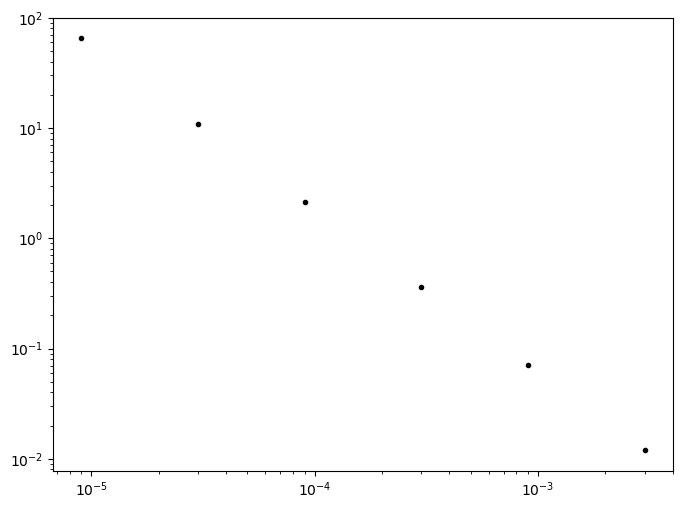

In [2]:
mbins = np.array((9.e-6, 3.e-5, 9.e-5, 3.e-4, 9.e-4, 3.e-3))
k = 0.39
alpha = -0.48

dnbins = 2.54e-3 * k * (3.33e5)**alpha * mbins**(alpha-1) 
dnbins_univ = 5.e-10 * k * (3.33e5)**alpha * mbins**(alpha-1)


fig = plt.figure(figsize=(8,6))
plt.plot(mbins, dnbins, 'k.')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [3]:
RVpowerLawData =np.vstack((mbins,dnbins)).T
np.savetxt('../data/planetsRVpowerLaw.txt',RVpowerLawData,fmt='%1.3e \t',header='M (M_s) \t dN/dMdV (M_s^-1 pc^-3)')

In [4]:
RVpowerLawData_univ =np.vstack((mbins,dnbins_univ)).T
np.savetxt('../data/planetsRVpowerLaw_univ.txt',RVpowerLawData_univ,fmt='%1.3e \t',header='M (M_s) \t dN/dMdV (M_s^-1 pc^-3)')

## individual bins

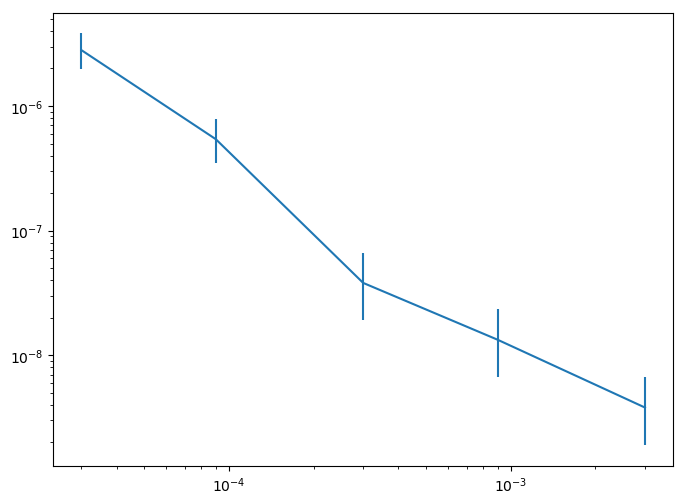

In [5]:
#If a sequence of shape 2xN, errorbars are drawn at -row1 and +row2 relative to the data.

mbins_lower = np.array((9.e-6, 3.e-5, 9.e-5, 3.e-4, 9.e-4))
mbins_upper = np.array((3.e-5, 9.e-5, 3.e-4, 9.e-4, 3.e-3))

mbins_intervals = mbins_upper - mbins_lower

fbins_indiv = (2.54e-3 * 0.01 * np.array((11.8,6.5,1.6,1.6,1.6))) / mbins_intervals
fbins_upperunc_indiv = (2.54e-3 * 0.01*np.array((4.3,3.0,1.2,1.2,1.2))) / mbins_intervals
fbins_lowerunc_indiv = (2.54e-3 * 0.01*np.array((3.5,2.3,0.8,0.8,0.8))) / mbins_intervals

fbins_indiv_univ = 5.e-10 * 0.01 * np.array((11.8,6.5,1.6,1.6,1.6)) / mbins_intervals
fbins_upperunc_indiv_univ = 5.e-10 * 0.01*np.array((4.3,3.0,1.2,1.2,1.2)) / mbins_intervals
fbins_lowerunc_indiv_univ = 5.e-10 * 0.01*np.array((3.5,2.3,0.8,0.8,0.8)) / mbins_intervals

#take the average mass in each mass bin
mbins_indiv = mbins_intervals / 2.

#If a sequence of shape 2xN, errorbars are drawn at -row1 and +row2 relative to the data.
fig = plt.figure(figsize=(8,6))
plt.errorbar(mbins_upper, fbins_indiv_univ, yerr=np.vstack((fbins_lowerunc_indiv_univ,fbins_upperunc_indiv_univ)))
plt.xscale('log')
plt.yscale('log')
plt.show()

In [6]:
RVbinsData =np.vstack((mbins_upper,fbins_indiv,fbins_upperunc_indiv,fbins_lowerunc_indiv)).T
np.savetxt('../data/planetsRVbins.txt',RVbinsData,fmt='%1.3e \t',header='M (M_s) \t dN/dMdV (M_s^-1 pc^-3) \t dN/dMdV_upperunc (M_s^-1 pc^-3) \t dN/dMdV_lowerunc (M_s^-1 pc^-3)')

In [7]:
RVbinsData_univ =np.vstack((mbins_upper,fbins_indiv_univ,fbins_upperunc_indiv_univ,fbins_lowerunc_indiv_univ)).T
np.savetxt('../data/planetsRVbins_univ.txt',RVbinsData_univ,fmt='%1.3e \t',header='M (M_s) \t dN/dMdV (M_s^-1 pc^-3) \t dN/dMdV_upperunc (M_s^-1 pc^-3) \t dN/dMdV_lowerunc (M_s^-1 pc^-3)')